In [11]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

# Model definition and parameters
model = pybamm.lithium_ion.SPM(
    options={
        "cell geometry": "pouch",
        "current collector": "potential pair",
        "dimensionality": 2,
        "thermal": "x-lumped",
    },
)


# Define parameters using PyBaMM's parameter interface
E_C = pybamm.Parameter("Positive electrode Young modulus [Pa]")
E_A = pybamm.Parameter("Negative electrode Young modulus [Pa]")
a_C = pybamm.Parameter("Positive electrode expansion coefficient")
a_A = pybamm.Parameter("Negative electrode expansion coefficient")
v_A = pybamm.Parameter("Positive electrode Poisson ratio")
v_C = pybamm.Parameter("Negative electrode Poisson ratio")
t_C = pybamm.Parameter("Positive electrode thickness [m]")
t_A = pybamm.Parameter("Negative electrode thickness [m]")
U = pybamm.Parameter("Total thickness relaxation [m]") #This is the total thickness variation. Set to 0 for a battery clamped when fully discharged (stochiometry of anode = 0).
N = pybamm.Parameter("Number of layers") 


# Set parameter values
parameter_values = pybamm.ParameterValues("Marquis2019")

parameter_values.update({"Positive electrode Young modulus [Pa]": 10**9}, check_already_exists=False)
parameter_values.update({"Negative electrode Young modulus [Pa]": 10**9}, check_already_exists=False)
parameter_values.update({"Positive electrode expansion coefficient": 0}, check_already_exists=False)
parameter_values.update({"Negative electrode expansion coefficient": 13/300}, check_already_exists=False)
parameter_values.update({"Negative electrode Poisson ratio": 0.2}, check_already_exists=False)
parameter_values.update({"Positive electrode Poisson ratio": 0.2}, check_already_exists=False)
parameter_values.update({"Number of layers": pybamm.Scalar(10)}, check_already_exists=False)
parameter_values.update({"Total thickness relaxation [m]": pybamm.Scalar(0)}, check_already_exists=False)

In [13]:
model.variables.search('y')


Average negative particle stoichiometry
Average positive particle stoichiometry
Battery negative electrode bulk open-circuit potential [V]
Battery negative particle concentration overpotential [V]
Battery open-circuit voltage [V]
Battery particle concentration overpotential [V]
Battery positive electrode bulk open-circuit potential [V]
Battery positive particle concentration overpotential [V]
Battery voltage [V]
Current collector current density [A.m-2]
Discharge capacity [A.h]
Discharge energy [W.h]
Electrode current density [A.m-2]
Electrode transport efficiency
Electrolyte concentration [Molar]
Electrolyte concentration [mol.m-3]
Electrolyte concentration concatenation [mol.m-3]
Electrolyte current density [A.m-2]
Electrolyte flux [mol.m-2.s-1]
Electrolyte potential [V]
Electrolyte transport efficiency
Exchange current density [A.m-2]
Gradient of electrolyte potential [V.m-1]
Gradient of negative electrolyte potential [V.m-1]
Gradient of positive electrolyte potential [V.m-1]
Gradie

Now we define the mathematica equations from the paper:

In [2]:
# Expansion: we include an ad-hoc prediction of the swelling based on experimental data.
# The anode swells up to 13% in volume, 4.4% in strain. The cathode strain is smaller, we assume it to be 0.
#These need to be correctly parametrised.

def swelling_A(stoc):
    return a_A * stoc

def swelling_C(stoc):
    return a_C * stoc

#this is the displacement in the unit cell
du = U/N


# Define custom stress functions using PyBaMM expressions

def sigma_xx(alpha_A, alpha_C):
    return (du - alpha_A * ((1 + v_A)/(1-v_A))*t_A - alpha_C * ((1 + v_C)/(1-v_C))*t_C)/(((1 + v_A)*(1-2 * v_A)*t_A)/((1-v_A)*E_A)+((1 + v_C)*(1-2 * v_C)*t_C)/((1-v_C)*E_C))

def sigma_A_yy_zz(alpha_A, alpha_C):
    return (v_A/(1-v_A)) * sigma_xx(alpha_A, alpha_C) - (E_A/(1-v_A)) * alpha_A

def sigma_C_yy_zz(alpha_A, alpha_C):
    return (v_C/(1-v_C)) * sigma_xx(alpha_A, alpha_C) - (E_C/(1-v_C)) * alpha_C



In [16]:
# Retrieve stoichiometry from model variables
x_p = model.variables['Positive electrode stoichiometry']
x_n = model.variables['Negative electrode stoichiometry']

# Register stress variables
model.variables["Negative electrode in-plane stress (yy,zz) [Pa]"] = sigma_A_yy_zz(swelling_A(x_p), swelling_C(x_n))
model.variables["Positive electrode in-plane stress (yy,zz) [Pa]"] = sigma_C_yy_zz(swelling_A(x_p), swelling_C(x_n))
model.variables["Negative electrode through-cell stress xx [Pa]"] = sigma_xx(swelling_A(x_p), swelling_C(x_n))
model.variables["Positive electrode through-cell stress xx [Pa]"] = sigma_xx(swelling_A(x_p), swelling_C(x_n))
model.variables["Positive electrode expansion strain"] = swelling_C(x_n)
model.variables["Negative electrode expansion strain"] = swelling_A(x_p)





In [18]:

# Setup solver and simulation
solver = pybamm.CasadiSolver(atol=1e-6, rtol=1e-3, root_tol=1e-3, mode="safe")

experiment = pybamm.Experiment(["Discharge at 2C for 40 minutes"])


sim = pybamm.Simulation(
    model, experiment=experiment, parameter_values=parameter_values, solver=solver
)

# Solve the model
sol = sim.solve()

2024-04-23 15:49:47.190 - [WARNING] callbacks.on_experiment_infeasible(231): 

	Experiment is infeasible: 'event: Minimum voltage [V]' was triggered during 'Discharge at 2C for 40 minutes'. The returned solution only contains up to step 1 of cycle 1. 


In [19]:
def plot_stress_and_expansion_distribution(solution,component, t):
    # Mesh for plotting
    L_y = parameter_values.evaluate(pybamm.Parameter("Electrode width [m]"))
    L_z = parameter_values.evaluate(pybamm.Parameter("Electrode height [m]"))
    y_plot = np.linspace(0, L_y, 101)
    z_plot = np.linspace(0, L_z, 101)
    
    # Evaluate stress and expansion variables at the given time
    plot_array = np.array(solution[component](y=y_plot, z=z_plot, t=t)).T

    # Plot the contour
    plt.figure(figsize=(3, 2), dpi=300)
    contour = plt.contourf(y_plot, z_plot,  plot_array, levels=100, cmap='viridis')  # Using the 'viridis' colormap
    plt.colorbar(contour)
    plt.xlabel(r"$y$ [m]")
    plt.ylabel(r"$z$ [m]")
    plt.show()

    

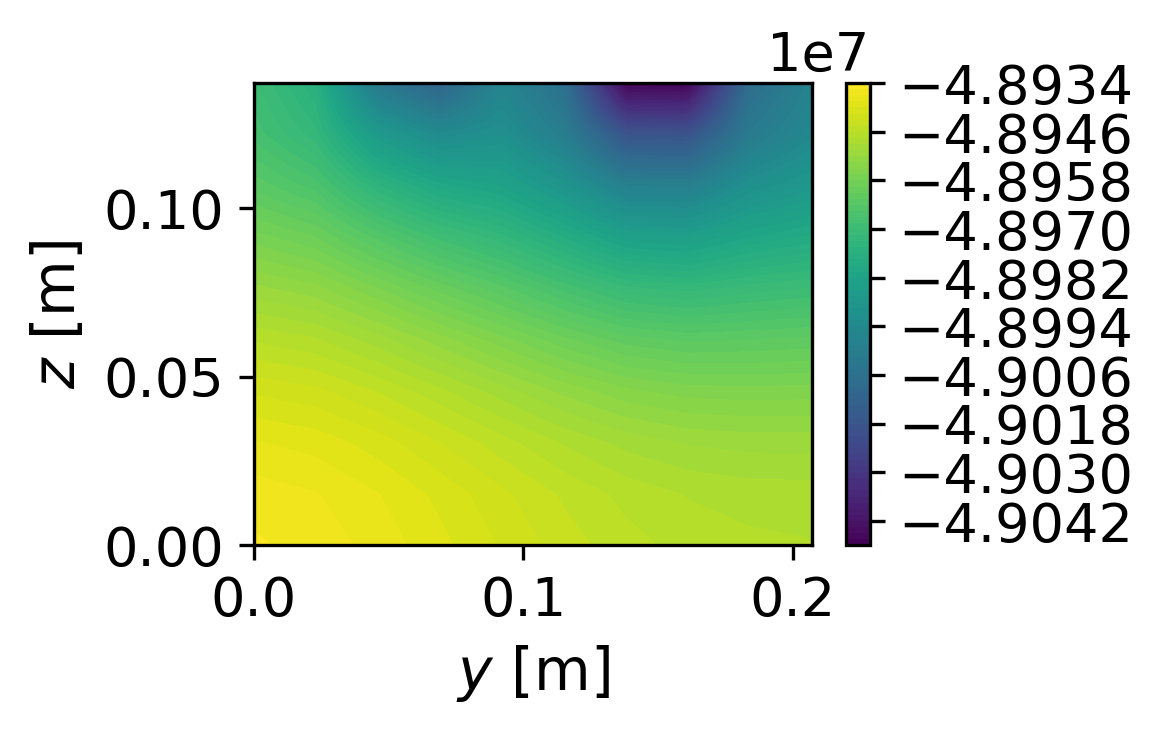

In [393]:
plot_stress_and_expansion_distribution(sol,"Negative electrode in-plane stress (yy,zz) [Pa]", t=15*60)  # Replace `100` with the specific time in seconds at which you want to plot the stress and expansion


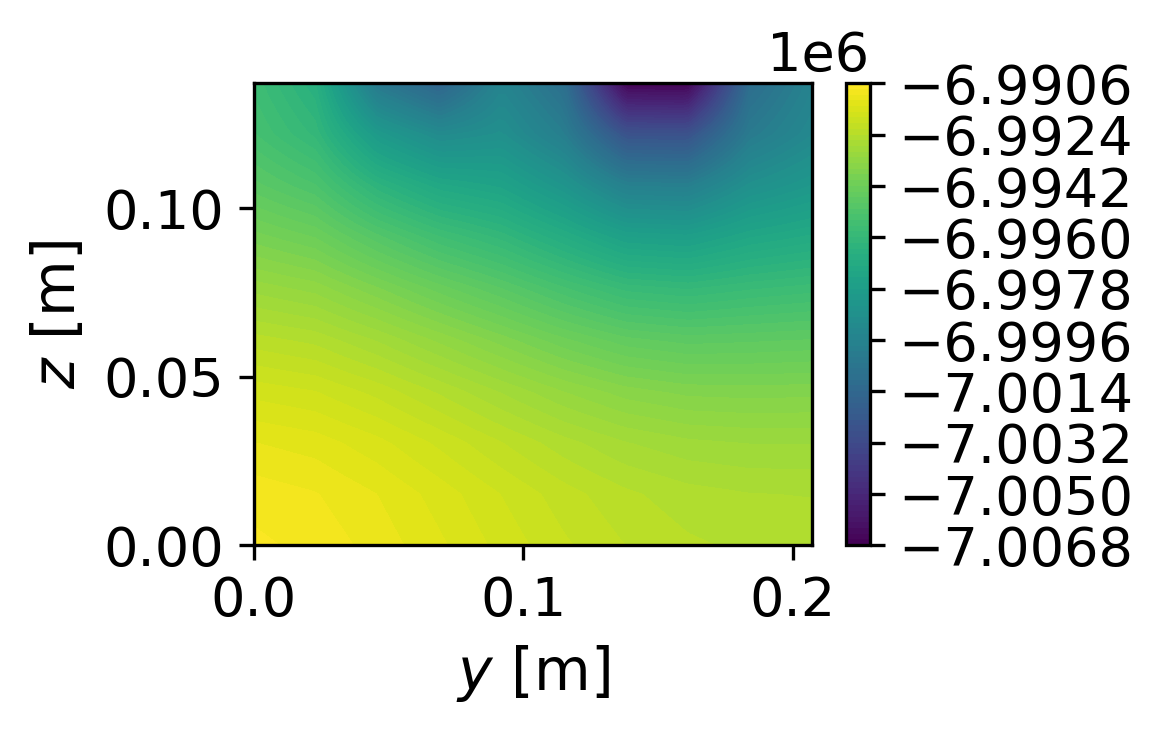

In [394]:
plot_stress_and_expansion_distribution(sol,"Positive electrode in-plane stress (yy,zz) [Pa]", t=15*60)  # Replace `100` with the specific time in seconds at which you want to plot the stress and expansion


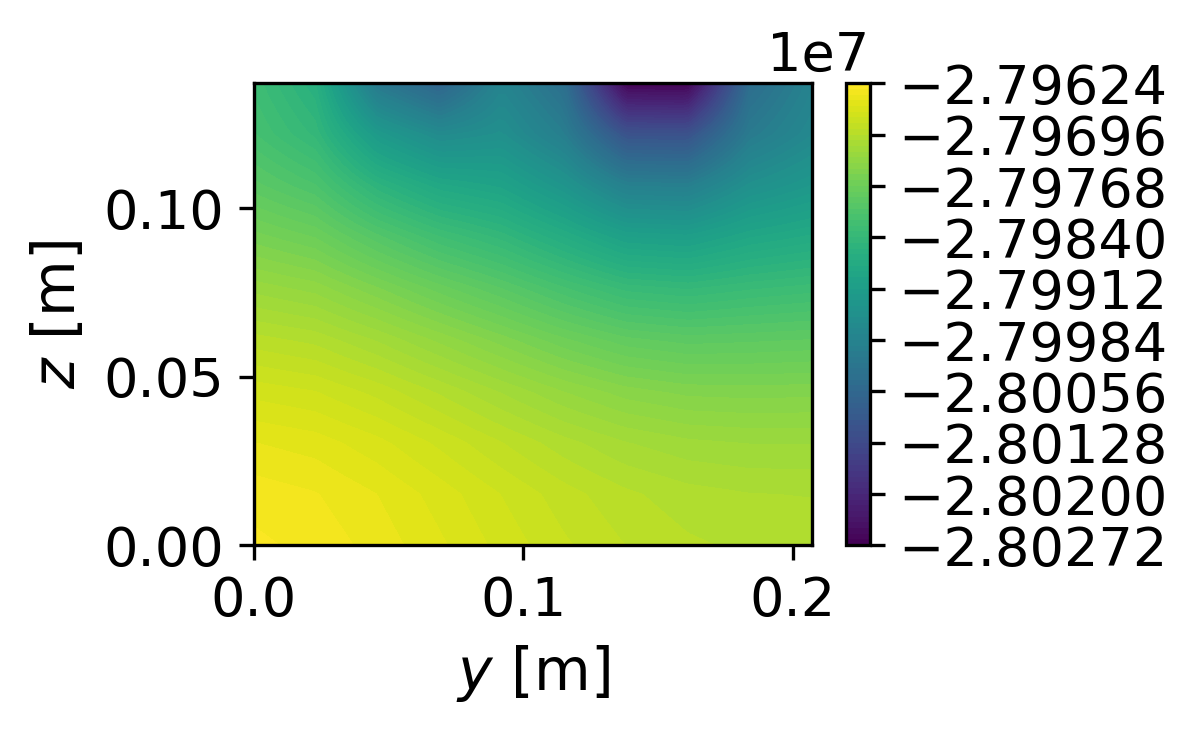

In [373]:
plot_stress_and_expansion_distribution(sol,"Positive electrode through-cell stress xx [Pa]", t=15*60)  # Replace `100` with the specific time in seconds at which you want to plot the stress and expansion


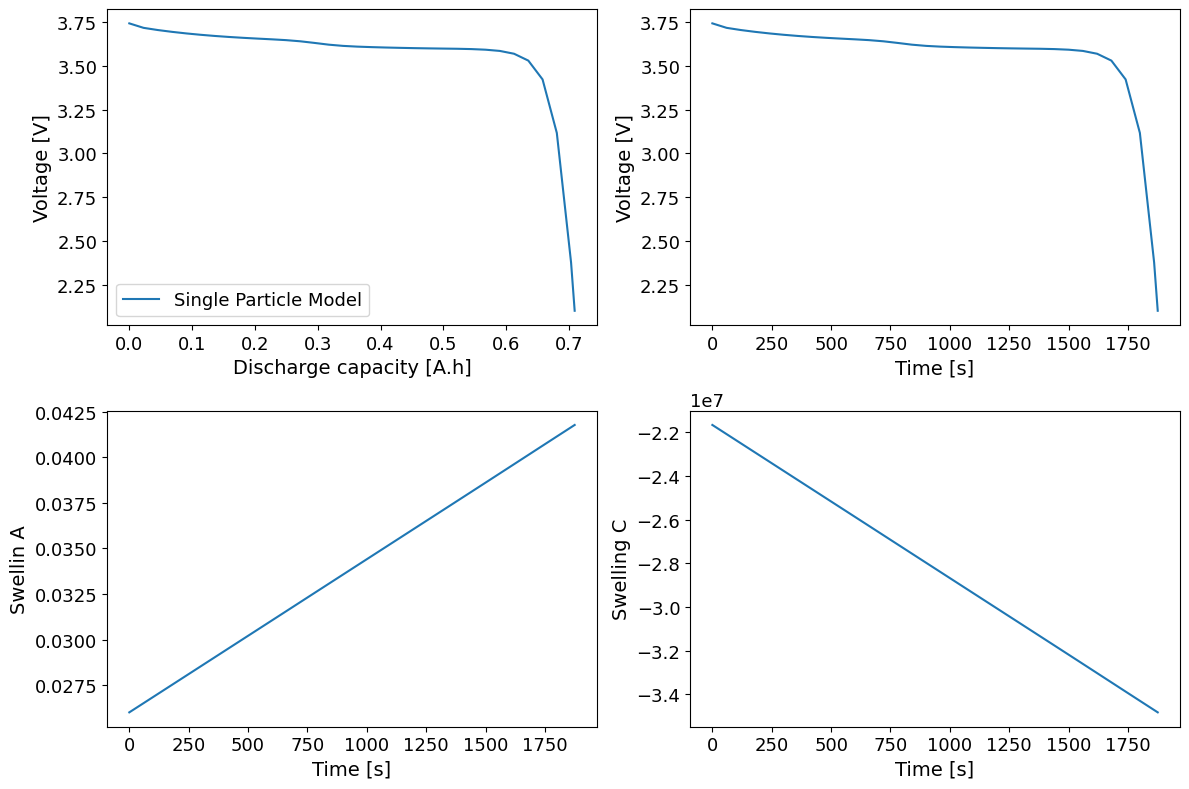

In [400]:
import matplotlib.pyplot as plt

plt.rc('axes', labelsize=14)  
plt.rc('xtick', labelsize=13)    
plt.rc('ytick', labelsize=13)  
plt.rc('legend', fontsize=13)   

fig, ax = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

ax[0, 0].plot(
    sol["Discharge capacity [A.h]"].entries, 
    sol["Terminal voltage [V]"].entries,
    label=sol.all_models[0].name
)
ax[0, 1].plot(
    sol["Time [s]"].entries, 
    sol["Terminal voltage [V]"].entries,
    label=sol.all_models[0].name
)    
ax[1, 0].plot(
    sol["Time [s]"].entries, 
    sol["Negative electrode expansion strain"].entries[4,4],
    label=sol.all_models[0].name
)    
ax[1, 1].plot(
    sol["Time [s]"].entries, 
    sol["Positive electrode through-cell stress xx [Pa]"].entries[4,4],
    label=sol.all_models[0].name
)        

ax[0, 0].set_xlabel("Discharge capacity [A.h]")    
ax[0, 0].set_ylabel("Voltage [V]")  
ax[0, 1].set_xlabel("Time [s]")    
ax[0, 1].set_ylabel("Voltage [V]")
ax[1, 0].set_xlabel("Time [s]")    
ax[1, 0].set_ylabel("Swellin A")
ax[1, 1].set_xlabel("Time [s]")    
ax[1, 1].set_ylabel("Swelling C")
ax[0, 0].legend()

In [338]:
1750/60

29.166666666666668

In [317]:
# Define plotting function
def plot(solution, t):
    # Post-process variables
    rhoP = solution["Average positive particle stoichiometry"]
    rhoN = solution["Average negative particle stoichiometry"]

    # Mesh for plotting
    L_y = parameter_values["Electrode width [m]"]
    L_z = parameter_values["Electrode height [m]"]
    y_plot = np.linspace(0, L_y, 41)
    z_plot = np.linspace(0, L_z, 41)
    
    # Create figure with subplots arranged horizontally
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Negative current collector potential
    phi_s_cn_plot = ax1.pcolormesh(
        y_plot, z_plot, rhoP(y=y_plot, z=z_plot, t=t).T, shading="gouraud"
    )
    ax1.set_xlabel(r"$y$ [m]")
    ax1.set_ylabel(r"$z$ [m]")
    ax1.set_title(r"$\rho_p$")
    fig.colorbar(phi_s_cn_plot, ax=ax1)

    # Positive current collector potential
    phi_s_cp_plot = ax2.pcolormesh(
        y_plot, z_plot, rhoN(y=y_plot, z=z_plot, t=t).T, shading="gouraud"
    )
    ax2.set_xlabel(r"$y$ [m]")
    ax2.set_ylabel(r"$z$ [m]")
    ax2.set_title(r"$\rho_n$")
    fig.colorbar(phi_s_cp_plot, ax=ax2)
    
    # Adjust layout to fit the subplots neatly
    plt.tight_layout()
    plt.show()



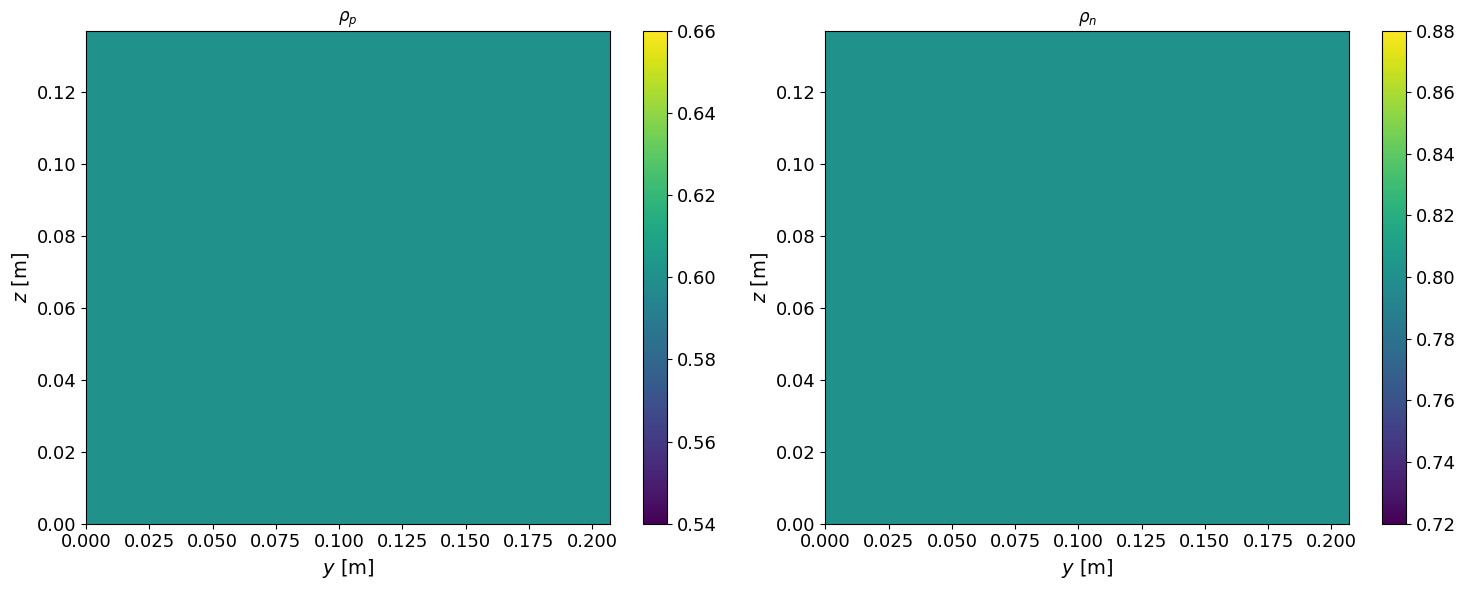

In [318]:
plot(sol, 0)

In [403]:
sol["Positive electrode in-plane stress (yy,zz) [Pa]"].entries

array([[[-5416666.66666667, -5521386.82478189, -5626169.60514794, ...,
         -8572557.81367714, -8678271.5316629 , -8704953.78302099],
        [-5416666.66666667, -5521401.09576547, -5626196.89955529, ...,
         -8572588.85361723, -8678285.98388344, -8704966.08054252],
        [-5416666.66666667, -5521436.0348321 , -5626263.38714753, ...,
         -8572654.10087929, -8678314.81698694, -8704990.17415807],
        ...,
        [-5416666.66666667, -5521856.97874439, -5627055.59020741, ...,
         -8573365.28089421, -8678620.79356053, -8705243.28550275],
        [-5416666.66666667, -5521939.6408304 , -5627208.8465836 , ...,
         -8573495.95953605, -8678676.49973066, -8705289.03922432],
        [-5416666.66666667, -5521978.6908058 , -5627280.53091607, ...,
         -8573552.57047991, -8678699.81721564, -8705307.86575917]],

       [[-5416666.66666667, -5521398.28880115, -5626191.67881321, ...,
         -8572587.29101484, -8678285.67074924, -8704965.94928296],
        [-5416666.6

In [ ]:
sol["Positive electrode in-plane stress (yy,zz) [Pa]"](0.)

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming alpha, rhoN, concentration functions are defined as per your previous code

time_t=15*60

# Generate a grid of y and z values
y = np.linspace(0, 0.207, 100)
z = np.linspace(0, 0.137, 100)
Y, Z = np.meshgrid(y, z)

# Initialize an empty array for Ff with the same shape as Y and Z
FC = np.zeros_like(Y)

# Iterate over each element in Y and Z
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        # Call the alpha function for each y, z pair and store the result in Ff
        FC[i, j] = sol["Positive electrode in-plane stress (yy,zz) [Pa]"](y=Y[i, j],z= Z[i, j], t = time_t)


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming alpha, rhoN, concentration functions are defined as per your previous code
time_t=15*60

# Generate a grid of y and z values
y = np.linspace(0, 0.207, 100)
z = np.linspace(0, 0.137, 100)
Y, Z = np.meshgrid(y, z)

# Initialize an empty array for Ff with the same shape as Y and Z
FA = np.zeros_like(Y)

# Iterate over each element in Y and Z
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        # Call the alpha function for each y, z pair and store the result in Ff
        FA[i, j] = sol["Negative electrode in-plane stress (yy,zz) [Pa]"](y=Y[i, j],z= Z[i, j], t = time_t)

In [31]:
from scipy.ndimage import gaussian_filter

# Compute the gradient of Ff
grad_FC_y, grad_FC_z = np.gradient(FC, y, z, edge_order=2)

# Smooth the gradients
grad_FC_y_smooth = gaussian_filter(grad_FC_y, sigma=3)  # Adjust sigma as needed
grad_FC_z_smooth = gaussian_filter(grad_FC_z, sigma=3)  # Adjust sigma as needed

# Compute the gradient of Ff
grad_FA_y, grad_FA_z = np.gradient(FA, y, z, edge_order=2)

# Smooth the gradients
grad_FA_y_smooth = gaussian_filter(grad_FA_y, sigma=3)  # Adjust sigma as needed
grad_FA_z_smooth = gaussian_filter(grad_FA_z, sigma=3)  # Adjust sigma as needed


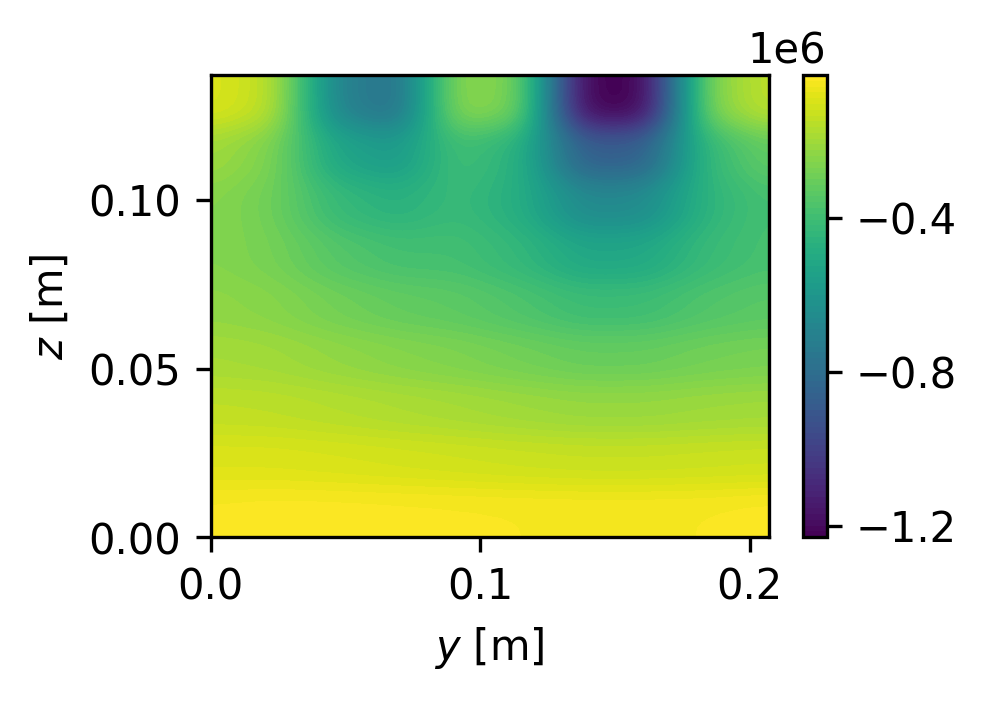

In [54]:
# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(Y, Z,  grad_FA_y_smooth, levels=100, cmap='viridis')  # Using the 'viridis' colormap
plt.colorbar(contour,ticks=[-400000,-800000,-1200000,-1600000])
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()

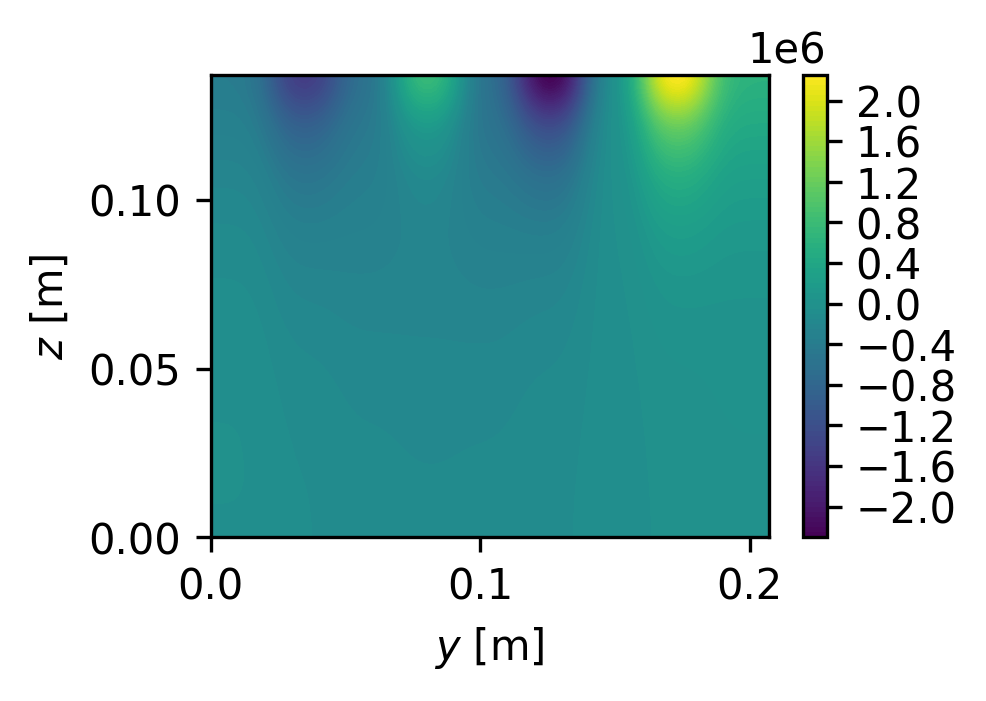

In [53]:
# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(Y, Z,  grad_FA_z_smooth, levels=100, cmap='viridis')  # Using the 'viridis' colormap
plt.colorbar(contour,ticks=[2000000,400000,800000,1200000,1600000,0,-400000,-800000,-1200000,-1600000,-2000000])
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()